# Library Imports

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import cv2
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset and Preprocessing

In [59]:
DATASET_LOCATION = "/content/drive/MyDrive/CVPR/animal_dataset/animal_dataset/"

In [60]:
import os
all_items = os.listdir(DATASET_LOCATION)
LABELS = [item for item in all_items if os.path.isdir(os.path.join(DATASET_LOCATION, item))]
LABELS.sort()

In [61]:
from PIL import Image
import os
import numpy as np

def load_images(location):
  images = []

  for class_label_index, folder_name in enumerate(LABELS):
    folder_path = os.path.join(location, folder_name)

    if not os.path.isdir(folder_path):
        continue

    for image_file_name in os.listdir(folder_path):
      img_path = os.path.join(folder_path, image_file_name)

      if os.path.isfile(img_path):
        try:
          img = Image.open(img_path)
          img_arr = np.array(img)
          images.append((img_arr, class_label_index))
        except Exception as e:
          print(f"Warning: Could not open {img_path} as an image. Error: {e}")
  return images

In [62]:
# Load images
images = load_images(DATASET_LOCATION) # image array, class label

panda


array([[[ 67,  95,  47],
        [ 72,  98,  53],
        [ 71,  93,  54],
        ...,
        [144, 152, 113],
        [180, 191, 151],
        [205, 216, 176]],

       [[ 67,  94,  49],
        [ 72,  97,  55],
        [ 74,  95,  56],
        ...,
        [154, 160, 122],
        [197, 204, 163],
        [223, 230, 188]],

       [[ 69,  94,  52],
        [ 70,  95,  55],
        [ 72,  92,  55],
        ...,
        [191, 193, 153],
        [214, 213, 169],
        [222, 219, 174]],

       ...,

       [[ 37,  40,  33],
        [ 37,  40,  33],
        [ 36,  39,  32],
        ...,
        [ 70, 107,  90],
        [ 65, 103,  88],
        [ 60,  98,  83]],

       [[ 36,  39,  32],
        [ 35,  38,  31],
        [ 35,  38,  31],
        ...,
        [ 62,  98,  84],
        [ 57,  95,  80],
        [ 52,  90,  75]],

       [[ 34,  37,  30],
        [ 33,  36,  29],
        [ 34,  37,  30],
        ...,
        [ 66,  98,  83],
        [ 62,  96,  80],
        [ 59,  93,  77]]], dtype=uint8)
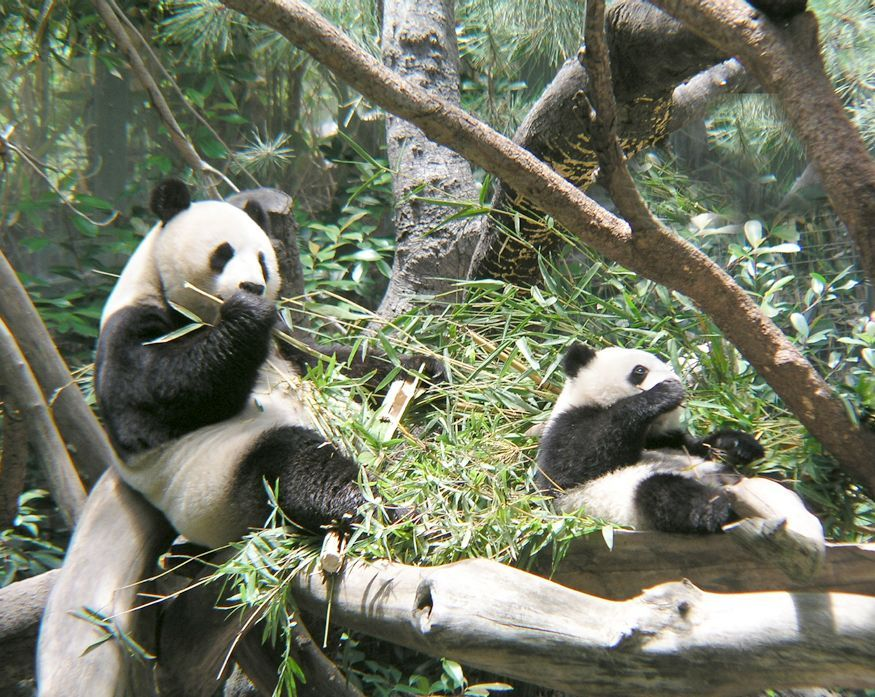

In [63]:
print(LABELS[images[250][1]])
images[250][0]

In [64]:
X = np.array([image[0] for image in images], dtype=object)
y = np.array([image[1] for image in images])
print(len(X), len(y))

300 300


In [65]:
# Normalizing images
normalized = False
if not normalized:
  X = X / 255.0
  normalized = True
X[:2]

array([array([[[0.77647059, 0.76078431, 0.71764706],
               [0.77647059, 0.76078431, 0.71764706],
               [0.77647059, 0.76078431, 0.71764706],
               ...,
               [0.7372549 , 0.72156863, 0.67843137],
               [0.7372549 , 0.72156863, 0.67843137],
               [0.7372549 , 0.72156863, 0.67843137]],

              [[0.77647059, 0.76078431, 0.71764706],
               [0.77647059, 0.76078431, 0.71764706],
               [0.77647059, 0.76078431, 0.71764706],
               ...,
               [0.74117647, 0.7254902 , 0.68235294],
               [0.74117647, 0.7254902 , 0.68235294],
               [0.74117647, 0.7254902 , 0.68235294]],

              [[0.77647059, 0.76078431, 0.71764706],
               [0.77647059, 0.76078431, 0.71764706],
               [0.77647059, 0.76078431, 0.71764706],
               ...,
               [0.74117647, 0.7254902 , 0.68235294],
               [0.74117647, 0.7254902 , 0.68235294],
               [0.74117647, 0.72549

### Grayscale Conversion

In [66]:
def grayscale_conversion(img_arr):
  if len(img_arr.shape) == 3:
    r, g, b = img_arr[:, :, 0], img_arr[:, :, 1], img_arr[:, :, 2]
    new_img = r*0.299 + 0.587*g + 0.114*b
    return new_img

  return img_arr

In [67]:
# convert images to grayscale
for i in range(len(images)):
  X[i] = grayscale_conversion(X[i])

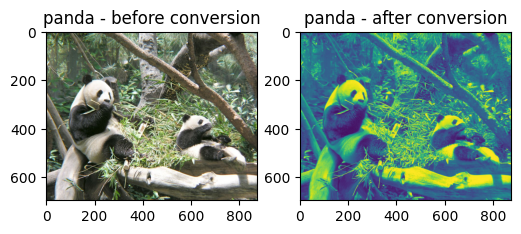

In [68]:
plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(images[250][0])
plt.title(f"{LABELS[y[250]]} - before conversion")
plt.subplot(122)
plt.imshow(X[250])
plt.title(f"{LABELS[y[250]]} - after conversion")
plt.show()

In [69]:
import matplotlib.pyplot as plt

### Resizing Images

In [70]:
def image_resize(img_arr, size=32, is_library=False):
  if is_library:
    resized_img = cv2.resize(img_arr, (size, size))
    return resized_img

  h, w = img_arr.shape
  resized_img = np.zeros((size, size))
  row_scale = h / size
  col_scale = w / size

  for i in range(32):
    for j in range(32):
      resized_img[i, j] = img_arr[int(i*row_scale), int(j*col_scale)]

  return resized_img

In [71]:
# Resize images
for i in range(len(images)):
  X[i] = image_resize(X[i], 32, is_library=True)

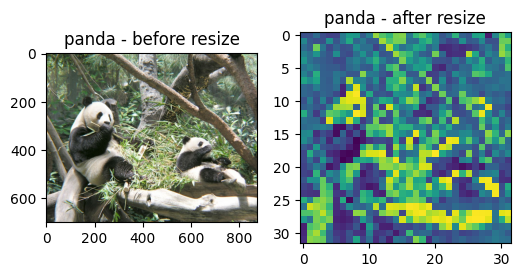

In [72]:
plt.figure(figsize=(6, 6))
plt.subplot(121)
plt.imshow(images[250][0])
plt.title(f"{LABELS[y[250]]} - before resize")
plt.subplot(122)
plt.imshow(X[250])
plt.title(f"{LABELS[y[250]]} - after resize")
plt.show()

# Model Building and Evaluation

In [73]:
# L1 distance
def L1_distance(a, b):
    return np.sum(np.abs(a - b))

# L2 distance
def L2_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [74]:
K_values = [1, 3, 5, 7, 9]

### KNN Prediction

In [75]:
def KNN_prediction(X_train, y_train, X_test, k, method="L2"):
  # print(X_train.shape, y_train.shape, X_test.shape)

  distances = []
  for i in range(len(X_train)):
    if method == "L1":
      d = L1_distance(X_test, X_train[i])
    else:
      d = L2_distance(X_test, X_train[i])
    distances.append((d, y_train[i]))

  distances.sort()
  top_k = distances[:k]

  labels = [label for label in top_k]
  predicted_label = max(set(labels), key=labels.count)

  return predicted_label

### Cross Validation

In [76]:
def cross_validation(X, y, K_values, method="L2"):
  print(X.shape, y.shape)
  fold_size = len(X) // 5
  accuracies = []
  preds = {k: [] for k in K_values}

  for k in K_values:
    fold_acc = []
    for fold in range(5):
      start = fold * fold_size
      end = (fold + 1) * fold_size
      # print(start, end)

      X_test = X[start:end]
      y_test = y[start:end]

      if fold == 0:
        X_train = X[end:]
        y_train = y[end:]
      else:
        X_train = np.concatenate([X[:start], X[end:]], axis=0)
        y_train = np.concatenate([y[:start], y[end:]], axis=0)

      correct = 0
      for i in range(len(X_test)):
        _, predicted_label = KNN_prediction(X_train, y_train, X_test[i], k, method)
        preds[k].append(predicted_label)

        # print(f"Predicted: {predicted_label}, Actual: {y_test[i]}")
        if predicted_label == y_test[i]:
          correct += 1

      fold_acc.append(correct / len(X_test))

    accuracies.append(np.mean(fold_acc))

  return accuracies, preds

In [77]:
def show_image(img_arr, label=None):
  plt.figure(figsize=(2, 2))
  plt.imshow(img_arr)
  if label is not None:
    plt.title(f"{LABELS[label]}")
  plt.show()

In [78]:
n = len(X)
n_train = int(0.8 * n)

n_train

240

### shuffle dataset

In [79]:
indices = np.arange(n)
np.random.shuffle(indices)
X_shuffled = X[indices]
y_shuffled = y[indices]

In [80]:
X_train = X_shuffled[:n_train]
y_train = y_shuffled[:n_train]

X_test = X_shuffled[n_train:]
y_test = y_shuffled[n_train:]

len(X_train), len(y_train), len(X_test), len(y_test)

(240, 240, 60, 60)

In [81]:
freq = {}
for i in range(len(y_train)):
  if y_train[i] in freq:
    freq[y_train[i]] += 1
  else:
    freq[y_train[i]] = 1

freq

{np.int64(2): 85, np.int64(0): 76, np.int64(1): 79}

In [82]:
pred = KNN_prediction(X_train, y_train, X_test[19], k=3)
pred[1]

np.int64(1)

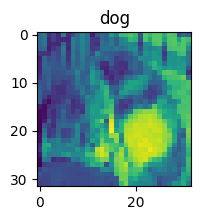

In [83]:
# Actual Label
show_image(X_shuffled[n_train+19], pred[1])

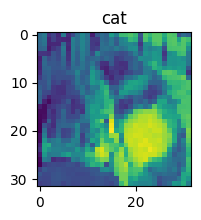

In [84]:
# Predicated Label
show_image(X_test[19], y_test[19])

# Results and Analysis

In [85]:
K_values = [1, 3, 5, 7, 9]
L1_accuracies, L1_preds = cross_validation(X_train, y_train, K_values, method="L1")
L2_accuracies, L2_preds = cross_validation(X_train, y_train, K_values, method="L2")

(240,) (240,)
(240,) (240,)


In [86]:
L1_accuracies

[np.float64(0.35),
 np.float64(0.3583333333333333),
 np.float64(0.3625),
 np.float64(0.3791666666666666),
 np.float64(0.35)]

In [87]:
L1_preds.keys()

dict_keys([1, 3, 5, 7, 9])

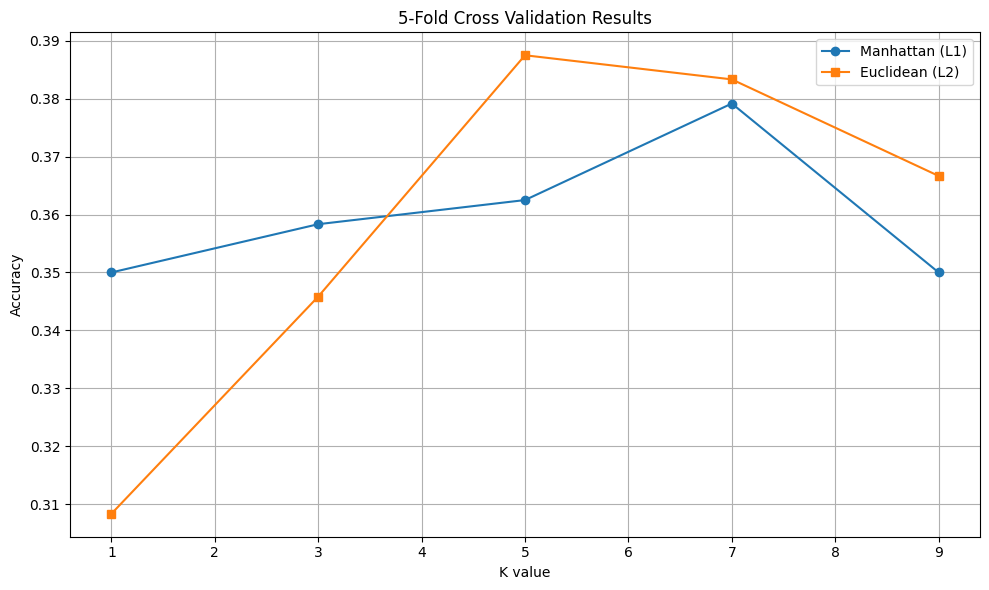

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(K_values, L1_accuracies, label="Manhattan (L1)", marker='o')
plt.plot(K_values, L2_accuracies, label="Euclidean (L2)", marker='s')
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.title("5-Fold Cross Validation Results")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [89]:
print(L1_preds.keys())
print(np.array(L1_preds[3]).shape)
np.array(y).shape

dict_keys([1, 3, 5, 7, 9])
(240,)


(300,)

# Discussion

The comparison between L1 (Manhattan) and L2 (Euclidean) distances showed the following results that we find from the graph of Accuracy VS K value:
- For K = 1, both L1 and L2 distances showed similar performance.

- For K = 3, 7, and 9, the L2 distance consistently achieved higher accuracy than L1.

- For K = 5, the L1 distance performed slightly better than L2.

L2 distance demonstrated more stable/consistent accuracy trends across the tested K values, whereas L1 showed some fluctuations.

Using normalized input features improved accuracy for both L1 and L2 distance metrics.

Trying additional K values may produce different performance patterns and could further support model tuning.

# Top 5 Predictions

L1 (Manhattan Distance)

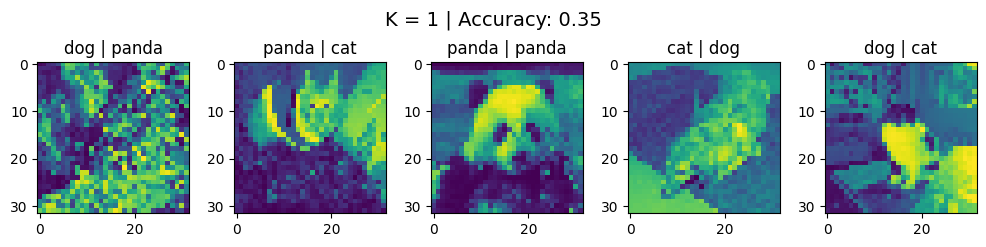

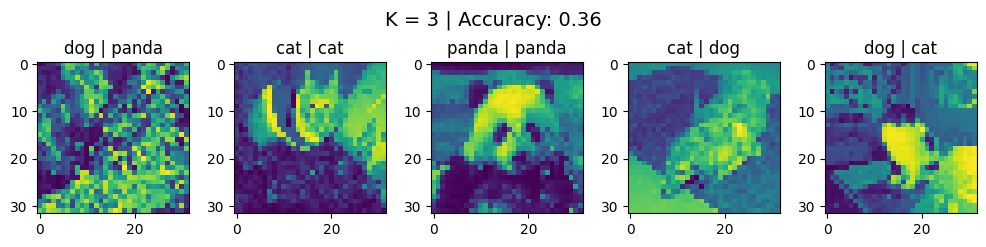

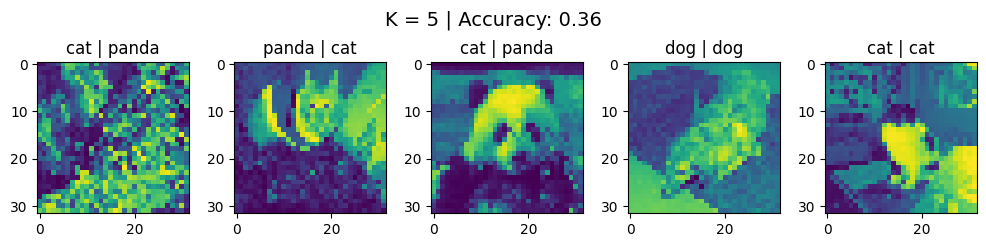

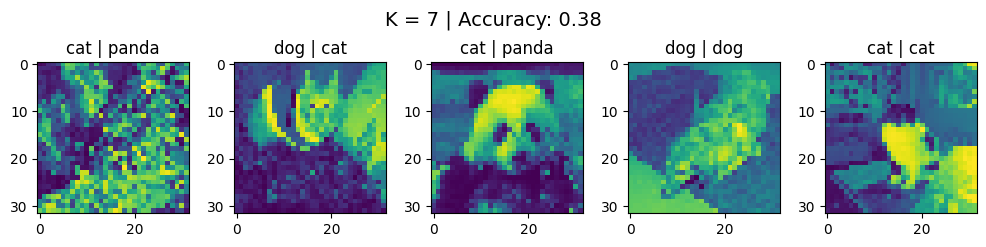

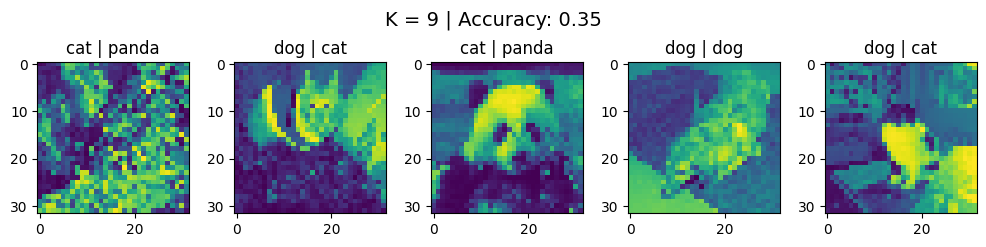

In [90]:
for idx, k in enumerate(K_values):
  plt.figure(figsize=(10,10))
  for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_shuffled[i])
    plt.title(f"{LABELS[L1_preds[k][i]]} | {LABELS[y_shuffled[i]]}")
  plt.suptitle(f"K = {k} | Accuracy: {L1_accuracies[idx]:.2f}", fontsize=14)
  plt.tight_layout()
plt.show()

L2 (Euclidean Distance)

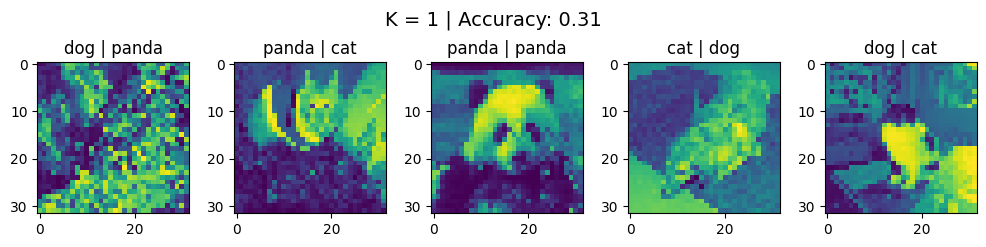

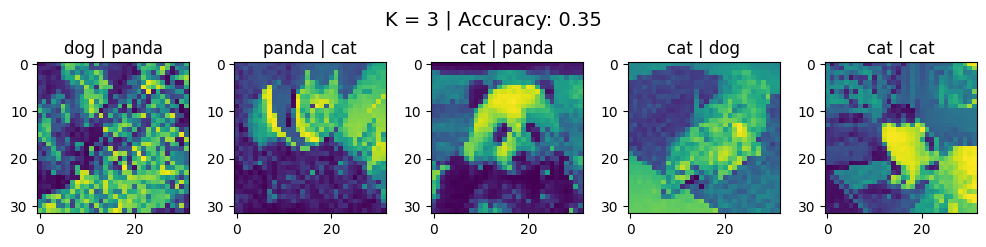

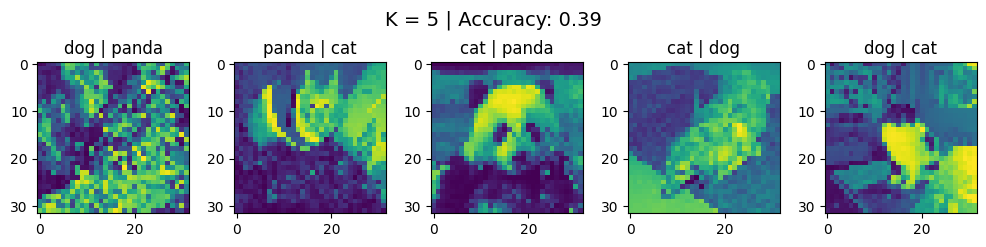

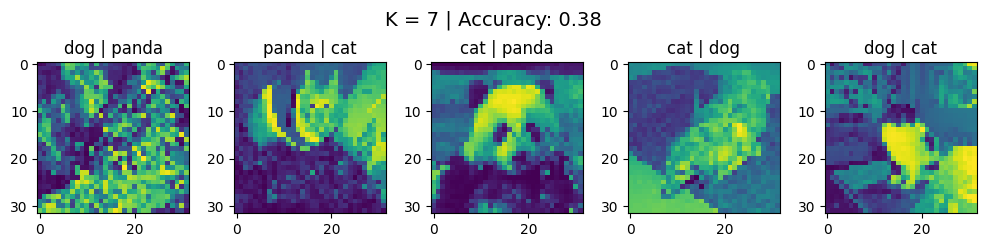

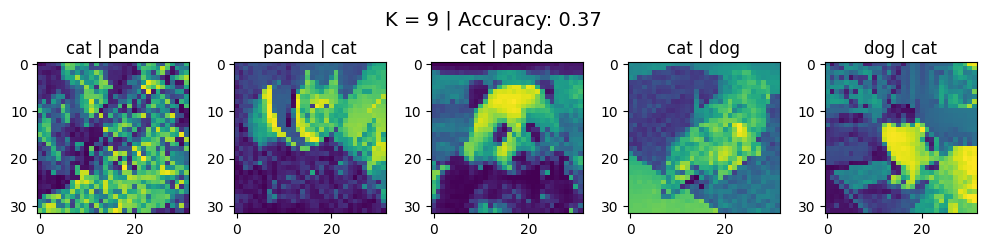

In [91]:
for idx, k in enumerate(K_values):
  plt.figure(figsize=(10,10))
  for i in range(5):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_shuffled[i])
    plt.title(f"{LABELS[L2_preds[k][i]]} | {LABELS[y_shuffled[i]]}")
  plt.suptitle(f"K = {k} | Accuracy: {L2_accuracies[idx]:.2f}", fontsize=14)
  plt.tight_layout()
  plt.show()

In [92]:
L1_accuracies

[np.float64(0.35),
 np.float64(0.3583333333333333),
 np.float64(0.3625),
 np.float64(0.3791666666666666),
 np.float64(0.35)]

In [93]:
L2_accuracies

[np.float64(0.30833333333333335),
 np.float64(0.3458333333333333),
 np.float64(0.3875),
 np.float64(0.3833333333333333),
 np.float64(0.36666666666666664)]